In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import spdiags
from scipy.sparse import diags
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicgstab
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import gmres
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython.display import HTML

In [19]:
m = 64
n = m * m
L = 10
x = [-L, L]
y = [-L, L]
delta = (2*L) / m

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j-1] = 0
    e4[m*j-1] = 1

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()
matA = matA/(delta**2)

diagonals = [e1.flatten(), -1 * e1.flatten(), e1.flatten(), -1 * e1.flatten()]
offsets = [-n+m, -m, m, n-m]

matB = spdiags(diagonals, offsets, n, n).toarray()
matB = matB / (2* delta)

diagonals = [e1.flatten(), -e1.flatten()]
offsets = [1, -1]

matC = spdiags(diagonals, offsets, n, n).toarray()

for i in range(m):
    matC[(i + 1)*m - 1, i *m] = 1
    matC[i*m, i*m+(m-1)] = -1
    matC[i*m, i*m - 1] = 0
    matC[i*m - 1, i*m] = 0

matC = matC / (2* delta)

In [20]:
def initial_conditions(case):
    if case == "original":
        return np.exp(-X**2 - Y**2/20)
    elif case == "opposite_gaussians":
        return np.exp(-((X + 5)**2 + Y**2/20)) - np.exp(-((X - 5)**2 + Y**2/20))
    elif case == "same_gaussians":
        return np.exp(-((X + 5)**2 + Y**2/20)) + np.exp(-((X - 5)**2 + Y**2/20))
    elif case == "colliding_pairs":
        return (np.exp(-((X + 5)**2 + (Y + 5)**2/20)) - np.exp(-((X - 5)**2 + (Y + 5)**2/20)) +
                np.exp(-((X + 5)**2 + (Y - 5)**2/20)) - np.exp(-((X - 5)**2 + (Y - 5)**2/20)))
    elif case == "random_vortices":
        vortices = np.zeros_like(X)
        for _ in range(15):
            x0, y0 = np.random.uniform(-10, 10, 2)
            amp = np.random.choice([-1, 1]) * np.random.uniform(0.5, 1.5)
            ellipticity = np.random.uniform(0.8, 1.2)
            vortices += amp * np.exp(-((X - x0)**2/20 + (ellipticity * (Y - y0))**2/20))
        return vortices

A = matA
B = matB
C = matC

tspan = np.arange(0, 4+0.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w0 = np.exp(-X**2 - Y**2/20)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

In [21]:
def spc_rhs(t, w0, nx, ny, K, nu):
    w2d = w0.reshape((nx, ny))
    wt = fft2(w2d)
    psit = -wt / K
    psi = np.real(ifft2(psit))
    psi = psi.flatten()
    rhs = (nu * A.dot(w0) + B.dot(w0) * C.dot(psi) - C.dot(w0) * B.dot(psi))
    return rhs

w0 = w0.flatten()
wtsol = solve_ivp(spc_rhs, [0, 4], w0, method= "RK45", t_eval=tspan, args=(nx, ny, K, nu))
A1 = []
for j, t in enumerate(tspan):
    w = wtsol.y[:N,j].reshape((nx,ny))
    A1.append(w)

In [22]:
# A/b
A[0, 0] = 2
start_time = time.time()
def a_b_rhs(t, w0, nu):
    psi = np.linalg.solve(A, w0)
    rhs = (nu * A.dot(w0) + B.dot(w0) * C.dot(psi) - C.dot(w0) * B.dot(psi))
    return rhs

w = np.exp(-X**2 - Y**2 / 20)
w0 = w.flatten()
wtsol = solve_ivp(a_b_rhs, [0, 4], w0, method= "RK45", t_eval=tspan, args=(nu,))
wtsol = wtsol.y
end_time = time.time()
elapsed_time = end_time - start_time
print (f"Elapsed time for A/b: {elapsed_time:.2f} seconds")
A2 = wtsol

Elapsed time for A/b: 12.49 seconds


In [23]:
# LU Decomp
start_time = time.time()
P, L, U = lu(A)
def LU_rhs(t, w0, nu):
    Pb = np.dot(P, w0)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y, lower=False)
    rhs = (nu * A.dot(w0) + B.dot(w0) * C.dot(psi) - C.dot(w0) * B.dot(psi))
    return rhs

w = np.exp(-X**2 - Y**2 / 20)
w0 = w.flatten()
wtsol = solve_ivp(LU_rhs, [0, 4], w0, method= "RK45", t_eval=tspan, args=(nu,))
wtsol = wtsol.y
end_time = time.time()
elapsed_time = end_time - start_time
print (f"Elapsed time for LU Decomp: {elapsed_time:.2f} seconds")
A3 = wtsol

Elapsed time for LU Decomp: 1.57 seconds


In [24]:
# BICGSTAB
start_time = time.time()
A_BIC = csc_matrix(A)
def BICG_rhs(t, w0, nu):
    psi, exit_code = bicgstab(A_BIC, w0, atol=1e-8)
    rhs = (nu * A_BIC.dot(w0) + B.dot(w0) * C.dot(psi) - C.dot(w0) * B.dot(psi))
    return rhs

w = np.exp(-X**2 - Y**2 / 20)
w0 = w.flatten()
wtsol = solve_ivp(BICG_rhs, [0, 4], w0, method= "RK45", t_eval=tspan, args=(nu,))
wtsol = wtsol.y
end_time = time.time()
elapsed_time = end_time - start_time
print (f"Elapsed time for BICGSTAB Decomp: {elapsed_time:.2f} seconds")
A4 = wtsol

Elapsed time for BICGSTAB Decomp: 1.61 seconds


In [25]:
# GMRES
start_time = time.time()
A_GMR = csc_matrix(A, dtype=float)
B_GMR = csc_matrix(B, dtype=float)
C_GMR = csc_matrix(C, dtype=float)
def GMRES_rhs(t, w0, nu):
    psi, exit_code = gmres(A_GMR, w0, atol=1e-8)
    rhs = (nu * A_GMR.dot(w0) + B_GMR.dot(w0) * C_GMR.dot(psi) - C_GMR.dot(w0) * B_GMR.dot(psi))
    return rhs

w = np.exp(-X**2 - Y**2 / 20)
w0 = w.flatten()
wtsol = solve_ivp(GMRES_rhs, [0, 4], w0, method= "RK45", t_eval=tspan, args=(nu,))
wtsol = wtsol.y
end_time = time.time()
elapsed_time = end_time - start_time
print (f"Elapsed time for GMRES Decomp: {elapsed_time:.2f} seconds")
A5 = wtsol

Elapsed time for GMRES Decomp: 11.15 seconds


In [29]:
# Function for generating animations
def animate_case(case_name):
    w0 = initial_conditions(case_name).flatten()
    wtsol = solve_ivp(spc_rhs, [0, 4], w0, method="RK45", t_eval=tspan, args=(nx, ny, K, nu))
    
    A1 = []
    for j, t in enumerate(tspan):
        w = wtsol.y[:, j].reshape((nx, ny))
        A1.append(w)

    # Create figure for animation
    fig, ax = plt.subplots()
    c = ax.pcolor(X, Y, A1[-1], shading='auto', cmap='viridis')
    fig.colorbar(c, ax=ax)
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

    # Update function
    def update(frame):
        c.set_array(A1[frame].ravel())
        time_text.set_text(f'Time: {tspan[frame]:.2f}')
        return c, time_text

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(A1), interval=100, blit=False)
    plt.close(fig)  # Prevent duplicate display
    return ani

# List of cases
cases = ["original", "opposite_gaussians", "same_gaussians", "colliding_pairs", "random_vortices"]

# Generate and save animations for all cases
for case in cases:
    print(f"Animating case: {case}")
    ani = animate_case(case)
    ani.save(f'vorticity_{case}.gif', writer='Pillow', fps=10)

Animating case: original


MovieWriter Pillow unavailable; using Pillow instead.


Animating case: opposite_gaussians


MovieWriter Pillow unavailable; using Pillow instead.


Animating case: same_gaussians


MovieWriter Pillow unavailable; using Pillow instead.


Animating case: colliding_pairs


MovieWriter Pillow unavailable; using Pillow instead.


Animating case: random_vortices


MovieWriter Pillow unavailable; using Pillow instead.


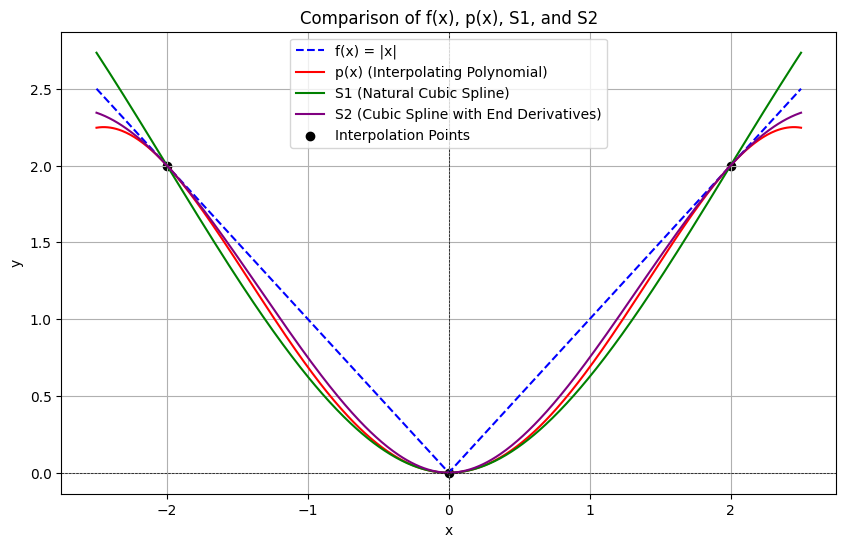

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Define the original function f(x) = |x|
def f(x):
    return np.abs(x)

# Define the interpolating polynomial p(x)
def p(x):
    return (-1/16) * x**4 + (3/4) * x**2

# Define the points for interpolation
x_points = np.array([-2, 0, 2])
y_points = f(x_points)
# Derivatives at endpoints for cubic spline
f_prime_neg2 = -1
f_prime_2 = 1

# Natural cubic spline (S1)
S1 = CubicSpline(x_points, y_points, bc_type='natural')

# Cubic spline with given derivatives at endpoints (S2)
S2 = CubicSpline(x_points, y_points, bc_type=((1, f_prime_neg2), (1, f_prime_2)))

# Generate x values for plotting
x_values = np.linspace(-2.5, 2.5, 500)

# Plotting
plt.figure(figsize=(10, 6))

# Plot f(x)
plt.plot(x_values, f(x_values), label="f(x) = |x|", linestyle="--", color="blue")

# Plot p(x)
plt.plot(x_values, p(x_values), label="p(x) (Interpolating Polynomial)", color="red")

# Plot S1 (Natural Cubic Spline)
plt.plot(x_values, S1(x_values), label="S1 (Natural Cubic Spline)", color="green")

# Plot S2 (Cubic Spline with Given Derivatives)
plt.plot(x_values, S2(x_values), label="S2 (Cubic Spline with End Derivatives)", color="purple")

# Add points of interpolation
plt.scatter(x_points, y_points, color="black", label="Interpolation Points")

# Formatting the plot
plt.title("Comparison of f(x), p(x), S1, and S2")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linewidth=0.5, linestyle="--")
plt.axvline(0, color='black', linewidth=0.5, linestyle="--")
plt.legend()
plt.grid()

# Show the plot
plt.show()
